# Data Exploration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load the riz training data:

In [2]:
from tomo_challenge import load_data, load_redshift

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


In [3]:
bands='riz'
include_colors=False
include_errors=False

In [4]:
train_file='/media/data2/tomo_challenge_data/ugrizy/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Loaded 8615613 training rows.


In [5]:
def prepare(band='i', n=100000, seed=123):
    n = n or len(train_data)
    colors = np.diff(train_data, axis=1)
    i = bands.index(band)
    gen = np.random.RandomState(seed)
    idx = gen.choice(len(train_data), n, replace=False)
    return np.concatenate((colors[idx], train_data[idx, i:i + 1]), axis=1), train_z[idx]

In [6]:
X, y = prepare(n=1000000)

In [96]:
def plotbins(features, redshift, npct=10, nhist=100, inset_pct=1, show_edges=True):
    ndata, nfeat = features.shape
    assert redshift.shape == (ndata,)
    D = np.concatenate((features, redshift.reshape(-1, 1)), axis=1).T
    
    # Calculate percentile bins for each feature.
    pct = np.linspace(0, 100, npct + 1)
    edges = np.percentile(D, pct, axis=1).T

    # Calculate inset ranges for histograms.
    ranges = np.percentile(D, (inset_pct, 100 - inset_pct), axis=1).T
    
    fig, axes = plt.subplots(nfeat + 1, nfeat + 1, figsize=(12, 12))
    for i in range(nfeat + 1):
        ax = axes[i, i]
        ax.hist(D[i], nhist, range=ranges[i])
        ax.set_xlim(*ranges[i])
        ax.set_yticks([])
        if show_edges:
            for edge in edges[i]:
                ax.axvline(edge, c='r', alpha=0.5, lw=1)
        for j in range(i + 1, nfeat + 1):
            ax = axes[j, i]
            hist, _, _ = np.histogram2d(D[i], D[j], [edges[i], edges[j]])
            ax.imshow(hist, origin='lower', interpolation='none', extent=[0, 100, 0, 100])
            ax = axes[i, j]
            ax.hist2d(D[j], D[i], nhist, range=(ranges[j], ranges[i]))
            if show_edges:
                for edge in edges[j]:
                    ax.axvline(edge, c='r', alpha=0.5, lw=1)
                for edge in edges[i]:
                    ax.axhline(edge, c='r', alpha=0.5, lw=1)

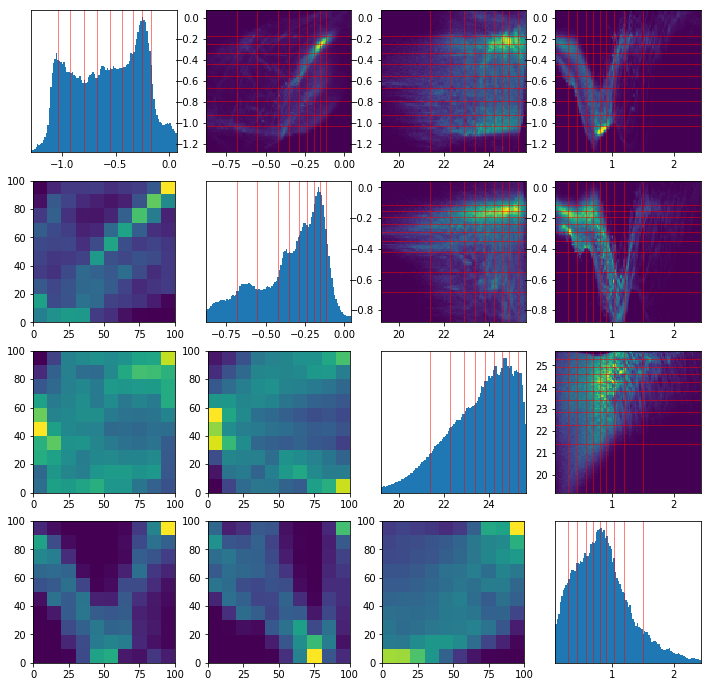

In [97]:
plotbins(X, y)

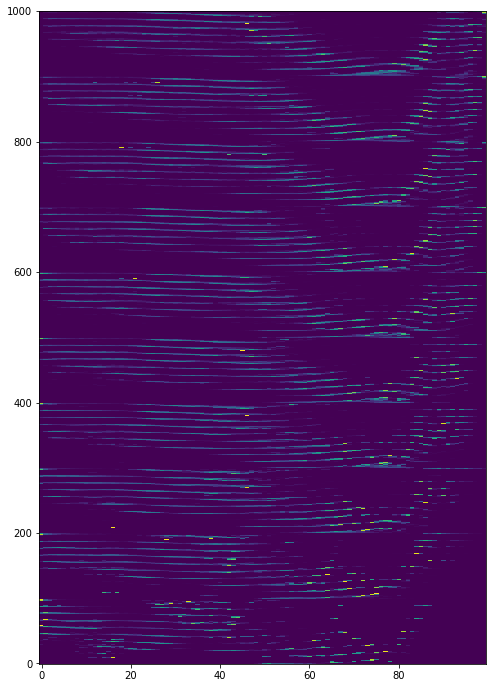

In [117]:
def plotz(features, redshift, npct=10, nzbin=100, pnorm=2):
    
    ndata, nfeat = features.shape
    D = features.T

    # Calculate percentile bins for each feature.
    pct = np.linspace(0, 100, npct + 1)
    edges = np.percentile(D, pct, axis=1).T
    
    # Assign each sample to a 3D bin.
    mul = 1
    idx = np.zeros(ndata, int)
    for i in range(nfeat):
        idx += mul * np.clip(np.digitize(D[i], edges[i]) - 1, 0, npct - 1)
        mul *= npct
    n3d = npct ** nfeat
        
    # Histogram the redshift distribution in each 3D bin.
    zhist = np.empty((n3d, nzbin))
    zedges = np.percentile(redshift, np.linspace(0, 100, nzbin + 1))
    for i in range(n3d):
        zhist[i], _ = np.histogram(redshift[idx == i], zedges)
    
    znorm = np.sum(zhist ** pnorm, axis=1, keepdims=True) ** (1 / pnorm)
    zhist = np.divide(zhist, znorm, where=znorm > 0, out=zhist)
    
    fig = plt.figure(figsize=(8, 12))
    q = slice(None)
    #q = np.argsort(zhist[:, nzbin // 2])
    plt.imshow(zhist[q], aspect='auto', origin='lower')
    
plotz(X, y)

In [145]:
def groupz(features, redshift, npct=10, nzbin=100, pnorm=2, min_groups=50, maxfrac=0.05, minfrac=0.0005):
    
    ndata, nfeat = features.shape
    D = features.T
    nmax = int(np.round(maxfrac * ndata))
    nmin = int(np.round(minfrac * ndata))
    assert nmax > nmin
    print('nmin', nmin, 'nmax', nmax, 'ndata', ndata)

    # Calculate percentile bins for each feature.
    pct = np.linspace(0, 100, npct + 1)
    edges = np.percentile(D, pct, axis=1).T
    
    # Assign each sample to a 3D bin.
    mul = 1
    idx = np.zeros(ndata, int)
    for i in range(nfeat):
        idx += mul * np.clip(np.digitize(D[i], edges[i]) - 1, 0, npct - 1)
        mul *= npct
    n3d = int(npct ** nfeat)

    # Histogram the redshift distribution in each 3D bin.
    zhist = np.empty((n3d, nzbin), int)
    zedges = np.percentile(redshift, np.linspace(0, 100, nzbin + 1))
    for i in range(n3d):
        zhist[i], _ = np.histogram(redshift[idx == i], zedges)
    zhist0 = zhist.copy()
    
    # Initialize iterative grouping.
    znorm = np.sum(zhist ** pnorm, axis=1, keepdims=True) ** (1 / pnorm)
    unit = np.divide(zhist, znorm, where=znorm > 0, out=np.zeros_like(zhist, float))
    active = znorm.reshape(-1) > 0
    nremaining = np.count_nonzero(active)
    idxbin = np.zeros(n3d, dtype=int)
    idxbin[active] = np.arange(1, nremaining + 1)
    upper = np.triu(np.ones((n3d, n3d)), 1)
    cosine = np.einsum('ij,kj->ik', unit, unit) * upper
    
    def remove(i):
        unit[i] = 0.
        cosine[:i, i] = 0.
        cosine[i, i+1:] = 0.
        active[i] = False

    # Run iterative grouping.
    while (nremaining > min_groups) and (np.min(zhist[active].sum(axis=1)) < nmin):
        assert np.all(idxbin[active] > 0)
        # Find the pair of bins that are closest.
        i1, i2 = np.unravel_index(np.argmax(cosine), cosine.shape)
        assert active[i1] and active[i2]
        #print(i1, i2, np.sum(zhist[active]))
        assert np.sum(zhist[active]) == ndata
        # Are we still below the threshold if we combine these?
        if np.sum(zhist[i1]) <= nmax:
            # Merge i1 and i2 into i1.
            sel1 = (idxbin == idxbin[i1])
            sel2 = (idxbin == idxbin[i2])
            print(i1, i2, np.where(sel1)[0], np.where(sel2)[0])
            idxnew = np.min(idxbin[i1], idxbin[i2])
            assert idxnew > 0
            idxbin[sel1] = idxnew
            idxbin[sel2] = idxnew
            zhist[i1] += zhist[i2]
            znorm[i1] = np.sum(zhist[i1] ** pnorm) ** (1 / pnorm)
            unit[i1] = zhist[i1] / znorm[i1]
            newcosine = unit.dot(unit[i1])
            cosine[i1, i1 + 1:] = newcosine[i1 + 1:]
            cosine[:i1, i1] = newcosine[:i1]
            # Remove i2.
            remove(i2)
            nremaining -= 1
        else:
            # Zero this cosine but leave both bins active.
            cosine[i1, i2] = 0.
            
    zhist_out = np.empty((nremaining, nzbin), int)
    for i, idx in enumerate(np.unique(idxbin)[1:]):
        sel = (idxbin == idx)
        zhist_out[i] = zhist[sel].sum(axis=0)
    assert np.array_equal(np.sort(zhist_out.sum(axis=1)), np.sort(zhist[active].sum(axis=1)))

    return zedges, idxbin, zhist[active]

In [146]:
%time zedges, idxbin, zhist = groupz(X, y, min_groups=100, maxfrac=0.02)

nmin 500 nmax 20000 ndata 1000000
7 209 [7] [209]


AxisError: axis 199 is out of bounds for array of dimension 0

In [124]:
zhist.shape

(100, 100)

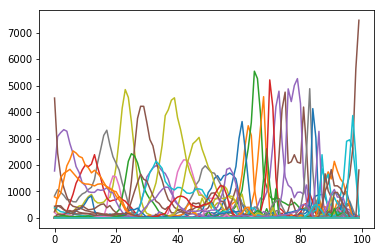

In [125]:
plt.plot(zhist.T);

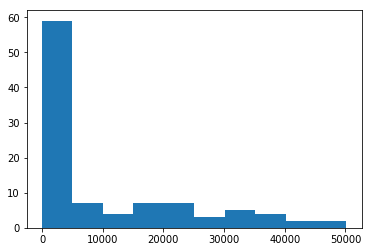

In [126]:
plt.hist(zhist.sum(axis=1));

In [127]:
zhist.sum()

1000000